## Importando as bibliotecas

In [1]:
import msgpack
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import OrderedDict

from geexhp.pypsg import PSG
from geexhp.utils import mod, estagios

from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats("svg")

import matplotlib.pyplot as plt
plt.rcParams.update({
    "xtick.top": True,
    "ytick.right": True,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "font.size": 12,
    "font.family": "Lato",
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "xtick.minor.visible": True,
    "ytick.minor.visible": True
    })

In [40]:
from matplotlib import lines as mlines
from math import atan2, degrees

def labelLine(line: mlines.Line2D, x: float, label: str = None, align: bool = True, **kwargs) -> None: 
    ax = line.axes
    xdata = line.get_xdata()
    ydata = line.get_ydata()

    # Find corresponding y-coordinate and angle of the line
    ip = 1
    for i in range(len(xdata)):
        if x < xdata[i]:
            ip = i
            break

    if xdata[ip] == xdata[ip - 1]:  # Avoid division by zero
        y = ydata[ip]
    else:
        y = ydata[ip - 1] + (ydata[ip] - ydata[ip - 1]) * (x - xdata[ip - 1]) / (xdata[ip] - xdata[ip - 1])

    if not label:
        label = line.get_label()

    if align:
        # Compute the slope
        dx = xdata[ip] - xdata[ip - 1]
        dy = ydata[ip] - ydata[ip - 1]
        ang = degrees(atan2(dy, dx))

        # Transform to screen coordinates
        pt = np.array([10**x, y]).reshape((1, 2)) if ax.get_xscale() == 'log' else np.array([x, y]).reshape((1, 2))
        trans_angle = ax.transData.transform_angles(np.array([ang]), pt)[0]
    else:
        trans_angle = 0

    # Set a bunch of keyword arguments
    if "color" not in kwargs:
        kwargs["color"] = line.get_color()

    if "horizontalalignment" not in kwargs and "ha" not in kwargs:
        kwargs["ha"] = "center"

    if "verticalalignment" not in kwargs and "va" not in kwargs:
        kwargs["va"] = "center"

    if "backgroundcolor" not in kwargs:
        kwargs["backgroundcolor"] = ax.get_facecolor()

    if "clip_on" not in kwargs:
        kwargs["clip_on"] = True

    if "zorder" not in kwargs:
        kwargs["zorder"] = 2.5

    ax.text(10**x if ax.get_xscale() == 'log' else x, y, label, rotation=trans_angle, **kwargs)

## Primeiro Teste - Carregando arquivo de configuração do HWO para Terra moderna

In [2]:
with open("../geexhp/config/default_habex.config", "rb") as f:
    config = OrderedDict(msgpack.unpack(f, raw=False))

In [3]:
moleculas = config["ATMOSPHERE-LAYERS-MOLECULES"].split(',')
pressoes = []
temperaturas = []
concentracoes_dict = {mol: [] for mol in moleculas}

for i in range(60):
    camada = config.get(f"ATMOSPHERE-LAYER-{i + 1}").split(',')
    pressao = float(camada[0])
    temperatura = float(camada[1])
    concentracoes = [float(valor) for valor in camada[2:]]
    
    pressoes.append(pressao)
    temperaturas.append(temperatura)
    for j, mol in enumerate(moleculas):
        concentracoes_dict[mol].append(concentracoes[j])

data = {
    "Pressao": pressoes,
    "Temperatura": temperaturas
}
data.update(concentracoes_dict)
mixing_ratio = pd.DataFrame(data)

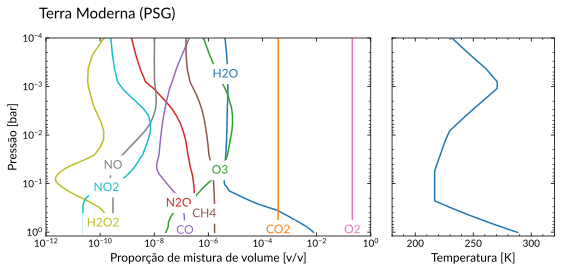

In [139]:
moleculas = ["H2O", "CO2", "O3", "N2O", "CO", "CH4", "O2", "NO", "H2O2", "NO2"]

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,4), width_ratios=[3,1.5], sharey=True)

for molecula in moleculas:
    line, = ax[0].plot(mixing_ratio[molecula], mixing_ratio["Pressao"], label=molecula)
    if molecula in ["H2O2", "O3", "CO"]:
        x_pos = np.quantile(line.get_xdata(), q = 0.75)
    else:
        x_pos = np.median(line.get_xdata())
    labelLine(line, x=x_pos, label=molecula, align=False)  
    
ax[0].invert_yaxis()
ax[0].axis([1e-12, 1, 1.2, 1e-4])
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set(xlabel="Proporção de mistura de volume [v/v]", ylabel="Pressão [bar]")

mixing_ratio.plot(x="Temperatura", y="Pressao", ax=ax[1], legend=False)
ax[1].invert_yaxis()
ax[1].axis([180, 320, 1.2, 1e-4])
ax[1].set(xlabel="Temperatura [K]", ylabel="Pressão [bar]")
ax[1].set_yscale("log")

fig.suptitle("Terra Moderna (PSG)", x=0.08, y=.95, horizontalalignment='left', 
             verticalalignment='top', fontsize = 15)
plt.tight_layout()
plt.show()

In [140]:
psg = PSG(server_url= "http://127.0.0.1:3000/api.php", timeout_seconds = 200)

Testing connection to PSG at http://127.0.0.1:3000/api.php ...
Connected to PSG with success.


In [141]:
config_HWC = config.copy()
estagios.terra_moderna(config_HWC)  # Aqui tem dois elementos que não estão presentes da atm
mod.instrumento(config_HWC, instrumento='HWC')
resultado = psg.run(config_HWC)

In [142]:
print(resultado["header"])

# WARNING | PUMAS | Some species, CH3Cl, do not have optimized correlated-k tables for the defined moderate resolutions, and will be analyzed at sub-par resolutions. In particular, there will be issues at the line cores.
# ------------------------------------------------------------------------
# Radiance spectrum
# NASA-GSFC Planetary Spectrum Generator (PSG) (Villanueva et al. 2018, 2022)
# Synthesized on Mon Jun  3 10:29:09 2024
# Doppler velocities [km/s] (vobs,vrot+vorb,vwidth,vrfl,vstr): 0.00000,0.00000,0.00000,0.00000,-0.00000
# ------------------------------------------------------------------------
# Spectra synthesized with the Planetary and Universal Model of Atmospheric Scattering (PUMAS, Villanueva et al. 2018, 2022)
# Multiple scattering method employing PSGDORT, NMAX:1 / LMAX:2 / gMAX:0.00
# ------------------------------------------------------------------------
# Spectral unit: Wavelength [um]
# Radiance unit: I/F [apparent albedo]
# Wave/freq Total Noise Exoplanet


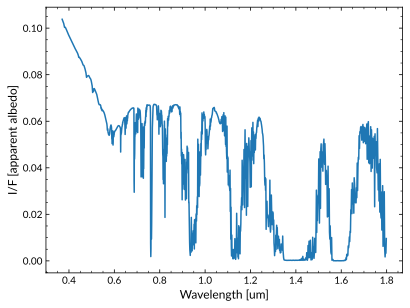

In [143]:
colunas = ["Wave/freq", "Total", "Noise", "Exoplanet"]
df_earth = pd.DataFrame(resultado["spectrum"], columns=colunas)

_, ax = plt.subplots()
ax.plot(df_earth["Wave/freq"], df_earth["Total"])
ax.set(xlabel="Wavelength [um]", ylabel="I/F [apparent albedo]");

In [144]:
def test_instrumento(config, instrumento):
    mod.instrumento(config, instrumento)
    resultado = psg.run(config)

    colunas = ["Wave/freq", "Total", "Noise", "Stellar", "Exoplanet"]
    return pd.DataFrame(resultado["spectrum"], columns=colunas)

In [145]:
config_SSUV = config.copy()
df_SSUV = test_instrumento(config_SSUV, "SS-UV")

config_SSVis = config.copy()
df_SSVis = test_instrumento(config_SSVis, "SS-Vis")

config_SSNIR = config.copy()
df_SSNIR = test_instrumento(config_SSNIR, "SS-NIR")

df = pd.concat([df_SSUV, df_SSVis, df_SSNIR]).reset_index(drop=True)

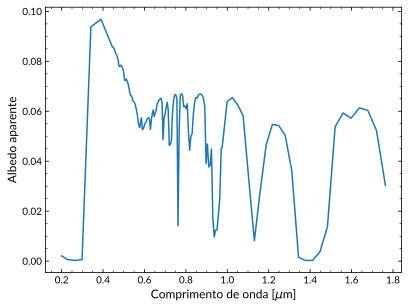

In [146]:
wave_freq = df["Wave/freq"]
total_albedo = df["Total"]

_, ax = plt.subplots()
ax.plot(wave_freq, total_albedo)
ax.set(xlabel="Comprimento de onda [$\mu$m]", ylabel="Albedo aparente");

## Teste 2 - Mudando as abundâncias

In [147]:
def test_abundancias(config, valor, gas):
    mod._gas(config, gas, valor)
    resultado = psg.run(config)

    colunas = ["Wave/freq", "Total", "Noise", "Exoplanet"]
    return pd.DataFrame(resultado["spectrum"], columns=colunas)

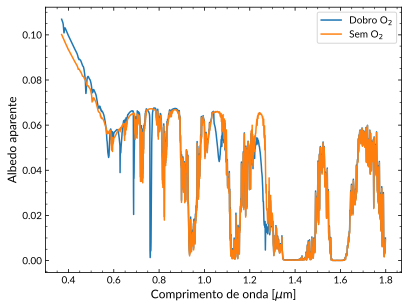

In [148]:
# Dobrando o valor de O2
config_dobro_02 = config_HWC.copy()
df_dobro_O2 = test_abundancias(config_dobro_02, gas="O2", valor=2)

# Tirando O2 da atmosfera
config_zero_02 = config_HWC.copy()
df_sem_O2 = test_abundancias(config_zero_02, gas="O2", valor=0)

_, ax = plt.subplots()
ax.plot(df_dobro_O2["Wave/freq"], df_dobro_O2["Total"], label="Dobro O${}_2$")
ax.plot(df_sem_O2["Wave/freq"], df_sem_O2["Total"], label="Sem O${}_2$")
ax.set(xlabel="Comprimento de onda [$\mu$m]", ylabel="Albedo aparente")
ax.legend();

## Teste 3 - Modificando a pressão atmosférica (mbar)

In [149]:
def test_pressao(config, pressao):
    config["ATMOSPHERE-PRESSURE"] = str(pressao)
    resultado = psg.run(config)

    colunas = ["Wave/freq", "Total", "Noise", "Exoplanet"]
    return pd.DataFrame(resultado["spectrum"], columns=colunas)

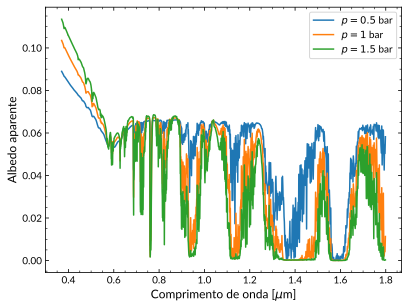

In [150]:
# 500 mbar = .5 bar
# O espectro não retornou nada para o dobro e 4x a pressão atmosférica
config_metade_atm = config_HWC.copy()
df_metade_atm = test_pressao(config_metade_atm, 500)

config_1_0_atm = config_HWC.copy()
df_1_0_atm = test_pressao(config_1_0_atm, 1000)

config_1_5_atm = config_HWC.copy()
df_1_5_atm = test_pressao(config_1_5_atm, 1500)

_, ax = plt.subplots()
ax.plot(df_metade_atm["Wave/freq"], df_metade_atm["Total"], label="$p = 0.5$ bar")
ax.plot(df_1_0_atm["Wave/freq"], df_1_0_atm["Total"], label="$p = 1$ bar")
ax.plot(df_1_5_atm["Wave/freq"], df_1_5_atm["Total"], label="$p = 1.5$ bar")
ax.set(xlabel="Comprimento de onda [$\mu$m]", ylabel="Albedo aparente")
ax.legend();

Quando a pressão atmosférica diminui, é geralmente um indicativo de uma atmosfera mais rarefeita. Em contrapartida, uma pressão atmosférica mais elevada sugere uma atmosfera mais densa e expansiva. A correlação entre a densidade atmosférica e a visibilidade das assinaturas espectrais está intrinsecamente ligada à interação fóton-molécula. Em uma atmosfera densa, as moléculas presentes têm mais oportunidades de interagir com os fótons, resultando em assinaturas espectrais mais pronunciadas. No entanto, quando a atmosfera é mais rarefeita, essas interações diminuem, levando a uma atenuação significativa das assinaturas espectrais.

## Geração de um modelo aleatório

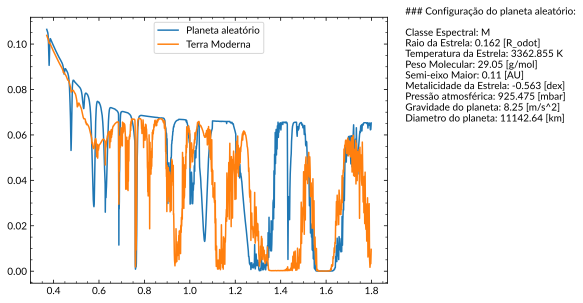

In [158]:
aleatorio = config_HWC.copy()
mod.rnd(aleatorio)
resultado_random = psg.run(aleatorio)
colunas = ["Wave/freq", "Total"]
df_rnd = pd.DataFrame(resultado_random["spectrum"][:, :2], columns=colunas)

CLASSE_ESPECTRAL = aleatorio['OBJECT-STAR-TYPE']
RAIO_ESTRELA = aleatorio['OBJECT-STAR-RADIUS']
TEMPERATURA_ESTRELA = aleatorio['OBJECT-STAR-TEMPERATURE']
PESO_MOLECULAR = round(aleatorio['ATMOSPHERE-WEIGHT'], 2)
SEMI_EIXO_MAIOR = round(aleatorio['OBJECT-STAR-DISTANCE'], 2)
METALICIDADE_ESTRELA = aleatorio['OBJECT-STAR-METALLICITY']
PRESSAO_ATMO = aleatorio["ATMOSPHERE-PRESSURE"]
GRAVIDADE_PLANETA = round(aleatorio['OBJECT-GRAVITY'], 2)
DIAMETRO_PLANETA = round(aleatorio['OBJECT-DIAMETER'], 2)

_, ax = plt.subplots()

ax.plot(df_rnd["Wave/freq"], df_rnd["Total"], label="Planeta aleatório")
ax.plot(df_earth["Wave/freq"], df_earth["Total"], label="Terra Moderna")
plt.legend(loc = "upper center")

texto = ("### Configuração do planeta aleatório:\n\n"
         f"Classe Espectral: {CLASSE_ESPECTRAL}\n"
         f"Raio da Estrela: {RAIO_ESTRELA} [R_odot]\n"
         f"Temperatura da Estrela: {TEMPERATURA_ESTRELA} K\n"
         f"Peso Molecular: {PESO_MOLECULAR} [g/mol]\n"
         f"Semi-eixo Maior: {SEMI_EIXO_MAIOR} [AU]\n"
         f"Metalicidade da Estrela: {METALICIDADE_ESTRELA} [dex]\n"
         f"Pressão atmosférica: {PRESSAO_ATMO} [mbar]\n"
         f"Gravidade do planeta: {GRAVIDADE_PLANETA} [m/s^2]\n"
         f"Diametro do planeta: {DIAMETRO_PLANETA} [km]\n"
         )

plt.text(1.05, 0.8, texto,
         horizontalalignment='left',
         verticalalignment='center',
         fontsize = 10, transform=plt.gca().transAxes)

plt.show()